# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from workspace_utils import keep_awake
from workspace_utils import  active_session
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
# set matplotlib to show in the notebook
%matplotlib inline
# set figure format for higher resolution
%config InlineBackend.figure_format = 'retina'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets

## for the training data, radomize the rotation, scaling, cropping, flipping
## for the testing and validation data, only crop the images
## for all data, create the tensor and normalize the color channel mean and std deviation

train_transforms = transforms.Compose([ transforms.RandomRotation(30),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])
test_valid_transforms = transforms.Compose([ transforms.Resize(255),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_valid_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=test_valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# TODO: Build and train your network

After looking at the PyTorch documentation for pretrained models for image classification, I decided to start with the model suggested in the project instructions, the VGG network.  The Pytorch document indicates there are 8 VGG models to chose from:
* VGG-11 and VGG-11 with batch normalization
* VGG-13 and VGG-13 with batch normalization
* VGG-16 and VGG-16 with batch normalization
* VGG-19 and VGG-19 with batch normalization

The number after VGG is an indication of the number of weight layers in the network (ref: https://www.quora.com/What-is-the-difference-between-VGG16-and-VGG19-neural-network).  From our course work, more weight layers usually correspond to increased processing resources being required, either time, horsepower or both.

PyTorch gives information on the Top-1 error and Top-5 error associated with each.  Ideally we would choose a model with a low top 1 and low top 5 error (ref:  https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/).  

When Batch Normalization is used, the training process can be accelerated and can reduce generalization errors (ref: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)

I am going to choose the VGG-16 with batch normalization model.

In [6]:
# load the model and look at the architecture
model = models.vgg16_bn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:09<00:00, 61050850.19it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [7]:
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

From the documentation on the data set being used, there are 102 flower categories.  The classifier with the VGG16_BN model has 1000.  We need to define a classifier that will take the 25088 inputs and provide 102 outputs. I am going to start with 3 layers:
* 25088 to 4096
* 4096 to 1024
* 1024 to 102

In [8]:
# define a new classifier 
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('fc1_relu', nn.ReLU()),
    ('fc1_drop', nn.Dropout(0.3)),
    ('fc2', nn.Linear(4096, 1024)),
    ('fc2_relu', nn.ReLU()),
    ('fc2_drop', nn.Dropout(0.3)),
    ('fc3', nn.Linear(1024, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

# replace the vgg16_bn classifier with the newly defined classifier
model.classifier = classifier

In [9]:
# look at the model with the new classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [10]:
#define the optimizer, only for the classifier, learning rate of 0.003
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

#define the criterion
criterion = nn.NLLLoss()

In [11]:
#define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# train the network and use the validation data to check loss and accuarcy during training
# number of training epochs - picke 8 based on trial and error
epochs = 8
# counter of the number of steps through the model
steps = 0
# capture the correct and incorrect predications being made by the model
running_loss = 0
# check the loss and accuracy every 10 steps
print_every = 10

#make sure the model is in the correct place
model.to(device)

#keep the workspace alive during training
with active_session():
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            # esnure labels and inputs are in the right location
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        valid_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                      f"Validation accuracy: {accuracy/len(validloader):.3f}")
                running_loss = 0
                model.train()

Epoch 1/8.. Train loss: 7.509.. Validation loss: 4.513.. Validation accuracy: 0.031
Epoch 1/8.. Train loss: 4.420.. Validation loss: 4.289.. Validation accuracy: 0.076
Epoch 1/8.. Train loss: 4.214.. Validation loss: 3.770.. Validation accuracy: 0.190
Epoch 1/8.. Train loss: 3.827.. Validation loss: 3.336.. Validation accuracy: 0.242
Epoch 1/8.. Train loss: 3.612.. Validation loss: 2.929.. Validation accuracy: 0.295
Epoch 1/8.. Train loss: 3.365.. Validation loss: 2.744.. Validation accuracy: 0.317
Epoch 1/8.. Train loss: 3.179.. Validation loss: 2.492.. Validation accuracy: 0.385
Epoch 1/8.. Train loss: 3.075.. Validation loss: 2.344.. Validation accuracy: 0.430
Epoch 1/8.. Train loss: 2.958.. Validation loss: 2.142.. Validation accuracy: 0.435
Epoch 1/8.. Train loss: 2.833.. Validation loss: 1.998.. Validation accuracy: 0.479
Epoch 2/8.. Train loss: 2.987.. Validation loss: 2.035.. Validation accuracy: 0.469
Epoch 2/8.. Train loss: 2.730.. Validation loss: 1.782.. Validation accuracy

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

I decided to make this a function so that I could use the function later to test the re-loaded model

In [8]:
# TODO: Do validation on the test set

### Method: test_network
### Input Parameters
###    model: the trained model to be used to classify images
###    test_data: batches of input images and labels that are formatted as pytorch tensors, image size 255 x 255 
### Output
###    The method will print statements with the loss and accuracy
def test_network(model, testData):
    accuracy = 0
    batch_loss = 0
    test_loss = 0

    #make sure to use the available device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #define the criterion
    criterion = nn.NLLLoss()
    
    model.to(device)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in testData:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Test loss: {test_loss/len(testData):.3f}.. "
          f"Test accuracy: {accuracy/len(testData):.3f}") 

In [14]:
test_network(model, testloader)

Test loss: 4.627.. Test accuracy: 0.005


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 
# reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training
model.class_to_idx = train_dataset.class_to_idx

torch.save({
    'epochs': epoch,
    'arch': 'vgg16_bn',
    'classifier': model.classifier,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': model.class_to_idx
}, 'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [6]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
### Method: load_checkpoint
###    This method is intended to run on a GPU.  If it is run a CPU, an error may occur
### Input Parameters
###    file: the name of the file that has a saved checkpoint, expecting a .pth file
### Output
###    model: a previously trained classification model that supports 102 outputs

def load_checkpoint(file):
    checkpoint = torch.load(file)
    model = models.vgg16_bn(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [9]:
# test the reloaded network with the test data  It should give the same accuracy as before the checkpoint was saved
test_load_model = load_checkpoint('checkpoint.pth')
test_network(test_load_model, testloader)

Test loss: 1.017.. Test accuracy: 0.744


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
### Method: process_image
###    This method takes in an image that was opened by PIL.  The image is scaled, cropped and normalized
###    before being converted to a pytorch tensor.
### Input Parameters
###    image: a PIL image object
### Output
###    rtnImage: a pytorach tensor representing an image of 224 x 224

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # resize the image so the shortest side is 256 pixels while maintaining aspect ratio
    if image.width < image.height:
        scaleFactor = image.width / 256
    else:
        scaleFactor = image.height / 256
    
    (width, height) = (int(image.width//scaleFactor), int(image.height//scaleFactor))
    
    tempImage = image.resize((width, height))
    
    # crop the centre 224 x 224 portion of the image
    # PIL coordinate system uses upper left as 0,0
    left = (width - 224)/2
    right = left + 224
    upper = (height - 224)/2
    lower = upper + 224
    
    tempImage = tempImage.crop((left, upper, right, lower))
    
    # convert to an np array, all the colour info is in the 3rd dimension
    tempImage = np.array(tempImage)
    
    # adjust the colour from 256 to floats between 0 and 1
    tempImage = tempImage/256
    
    # adjust for mean and std dev in the colour
    mean = [0.485, 0.456, 0.406]
    std_dev = [0.229, 0.224, 0.225]
    tempImage = (tempImage - mean)/std_dev
    
    #adjust the image dimensions
    tempImage = np.transpose(tempImage, (2, 0, 1))
    
    #convert to a pytorch tensor
    rtnImage = torch.from_numpy(tempImage)
    
    #return the processed image
    return rtnImage

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [11]:
### Method: imshow
###    This method was as part of the project. It takes does the reverse process of the method process_image
###    and then plots the image.
### Input Parameters
###    image: a pytorch tensor
### Output
###    ax: the matplot axes information

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

I selected the following test image. :

<img src='flowers/valid/1/image_06739.jpg' width=250px>

torch.Size([3, 224, 224])


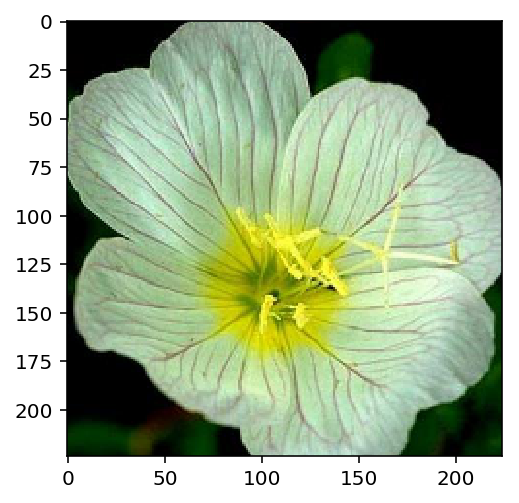

In [12]:
# Test of process image

# get an image
testImagePath = 'flowers/valid/1/image_06739.jpg'
testImage = Image.open(testImagePath)

# process the image
processImage = process_image(testImage)
print(processImage.shape)

# call the provided function
imshow(processImage)

The image is a cropped version of the orignal image, so my function process_image seems to work as expected.

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [13]:
### Method: predict
###    Predict the class of an image using the image model that was trained earlier in the project.
###    The outputs is returned
### Input Parameters
###    image_path: the path to the image of interest
###    model: the trained model
###    topk: optional default = 5; the number of likely classes and probabilities to be returned
### Output
###    probs: numpy array of the probabilities associated with the topk predicted classes
###    classes: numpy array of strings containing the topk predicted classes
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device", device)
    
    model.to(device)
    model.eval()
    
    # open the image in the path
    image = Image.open(image_path)
    # process the image
    imageTensor = process_image(image).view([1, 3, 224, 224]).float().to(device)
    
    # use the model to determine what the image is
    with torch.no_grad():
        logps = model.forward(imageTensor)
    
    ps = torch.exp(logps)
    
    top_p, top_class = ps.topk(topk, dim=1)
    
    # top_class will be an array that has values from 0..101
    # we need an array of strings with values from '1' to '102'
    top_class = top_class + 1
    # return the probabilities and classes
    return np.array(top_p)[0], np.array(top_class)[0].astype('str')
    

In [20]:
# use the test image from before
#predImage, predLabels = next(iter(trainloader))
testImagePath = 'flowers/valid/2/image_05094.jpg'
probs, classes = predict(testImagePath, test_load_model)
print(probs)
print(classes)

device cuda
[  1.00000000e+00   5.29016692e-11   6.43344590e-13   4.87804512e-13
   3.98928774e-13]
['15' '79' '94' '100' '51']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [20]:
probs

array([ 0.20743935,  0.09261233,  0.06787573,  0.05707958,  0.05631949], dtype=float32)

In [21]:
classes

array(['1', '46', '69', '50', '77'], 
      dtype='<U21')

In [21]:
#convert the classes to class names
classesNames = [cat_to_name[number] for number in classes]

#make a pandas series
plotSer = pd.Series(probs, classesNames)
plotSer

yellow iris       1.000000e+00
toad lily         5.290167e-11
foxglove          6.433446e-13
blanket flower    4.878045e-13
petunia           3.989288e-13
dtype: float32

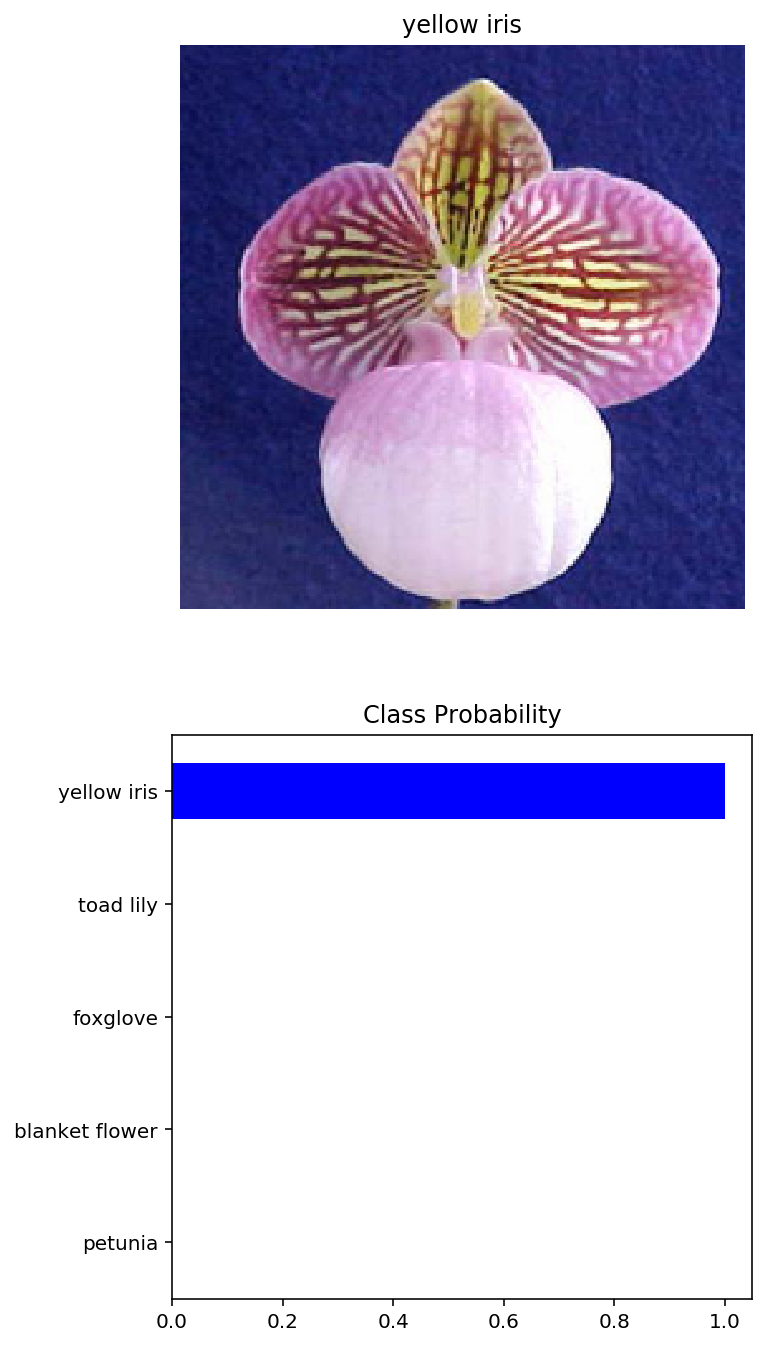

In [24]:
# TODO: Display an image along with the top 5 classes
# open and process the testImage
testImage = Image.open(testImagePath)
plotImage = process_image(testImage)

fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
imshow(plotImage, ax1)
ax1.set_title(classesNames[0])
ax1.axis('off')
ax2.set_title("Class Probability")
plotSer.plot.barh(ax=ax2, color=['blue']).invert_yaxis()
fig.tight_layout(pad=3.0)